In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## The gamma distribution

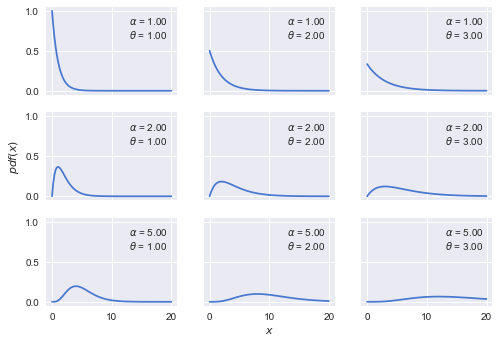

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')
plt.savefig('B04958_04_00.png', dpi=300, figsize=(5.5, 5.5));

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

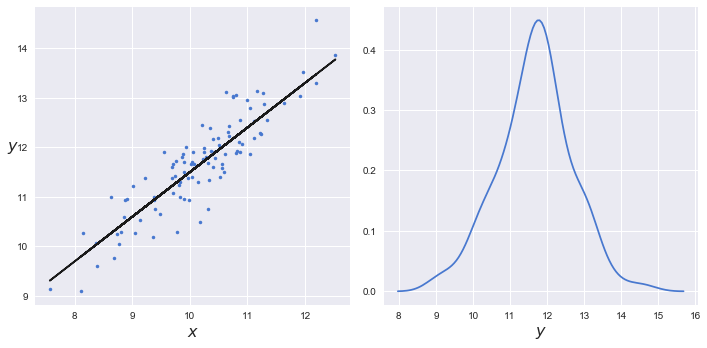

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300, figsize=(5.5, 5.5))

In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    # ## In this example we are deliberativelly choosing metropolis sampler
    start = pm.find_MAP() 
    step = pm.Metropolis() 
    trace = pm.sample(10000, step=step, start=start)   

         Current function value: 67.459649
         Iterations: 15
         Function evaluations: 28
         Gradient evaluations: 27


100%|██████████| 10500/10500 [00:07<00:00, 1448.74it/s]


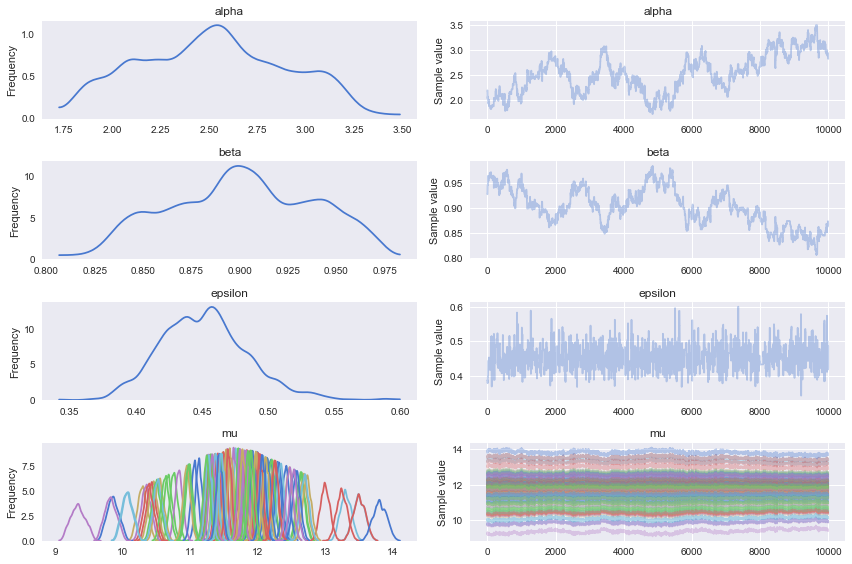

In [6]:
pm.traceplot(trace)
plt.savefig('B04958_04_03.png', dpi=300, figsize=(5.5, 5.5))

In [7]:
#pm.df_summary(trace)

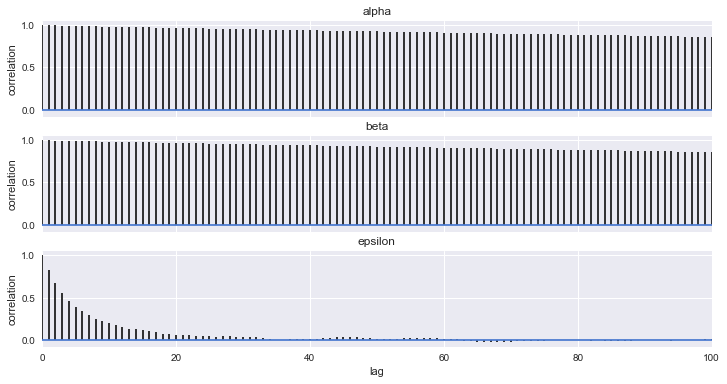

In [8]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)
plt.savefig('B04958_04_04.png', dpi=300, figsize=(5.5, 5.5));

### Modyfing the data before running the models

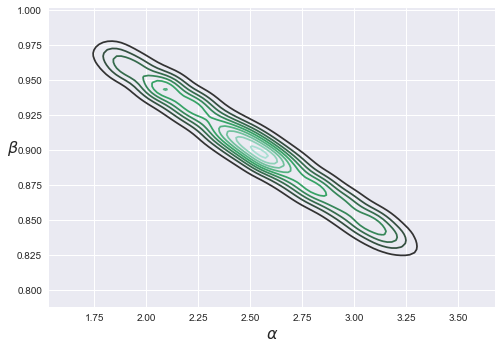

In [9]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)
plt.savefig('B04958_04_05.png', dpi=300, figsize=(5.5, 5.5));

### Changing the sampling method

In [10]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP() 
    step = pm.NUTS() 
    trace_n = pm.sample(2000, step=step, start=start)
    
    # remember now it is recomended to let PyMC3 choose the sampler and starting points for you. 
    # Trying replacing the above 3 lines with:
    # trace_n = pm.sample(2000)

         Current function value: 67.459649
         Iterations: 15
         Function evaluations: 28
         Gradient evaluations: 27


100%|██████████| 2500/2500 [00:42<00:00, 61.04it/s]


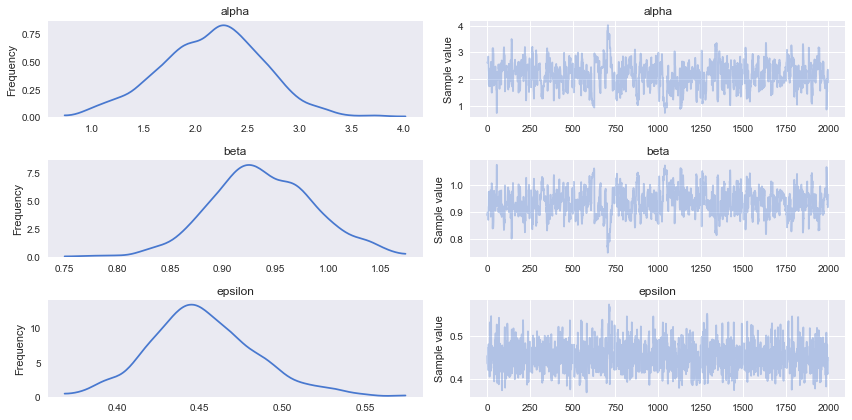

In [11]:
pm.traceplot(trace_n, varnames);

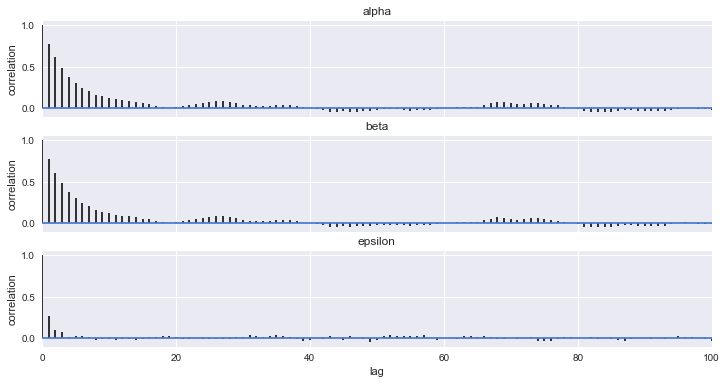

In [12]:
pm.autocorrplot(trace_n, varnames);

In [13]:
pm.df_summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.16,0.50,2.80e-02,1.07,3.04
beta,0.94,0.05,2.74e-03,0.85,1.04
epsilon,0.45,0.03,9.47e-04,0.39,0.52


### Posterior predictive checks

In [14]:
ppc = pm.sample_ppc(trace_n, samples=231, model=model_n)

100%|██████████| 231/231 [00:04<00:00, 47.92it/s]


/home/osvaldo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


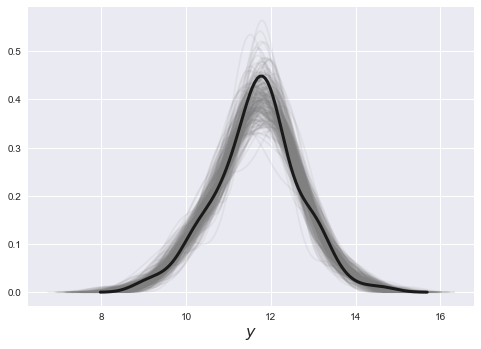

In [15]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.1, c='gray')
# actual data
sns.kdeplot(y, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16);

### interpreting the posterior

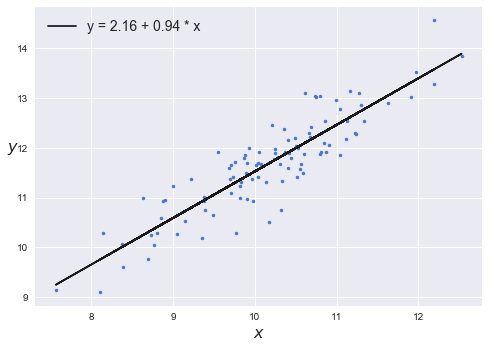

In [16]:
plt.plot(x, y, 'b.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_06.png', dpi=300, figsize=(5.5, 5.5));

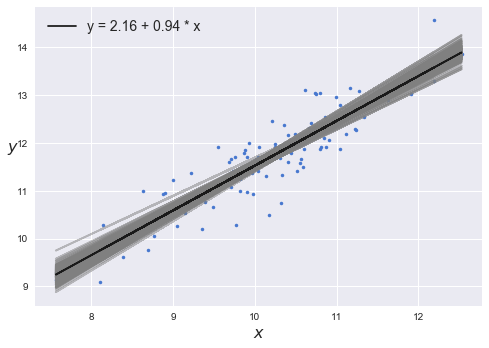

In [17]:
plt.plot(x, y, 'b.');

idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_07.png', dpi=300, figsize=(5.5, 5.5));

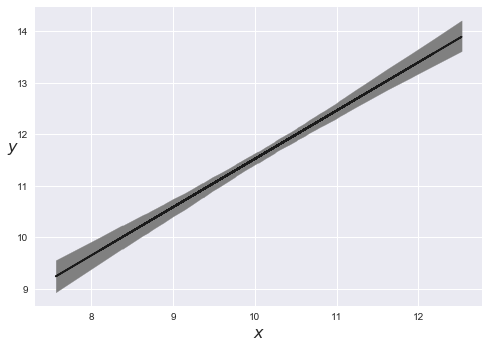

In [18]:
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_08.png', dpi=300, figsize=(5.5, 5.5));

In [19]:
ppc = pm.sample_ppc(trace_n, samples=1000, model=model_n)

100%|██████████| 1000/1000 [00:00<00:00, 1439.02it/s]


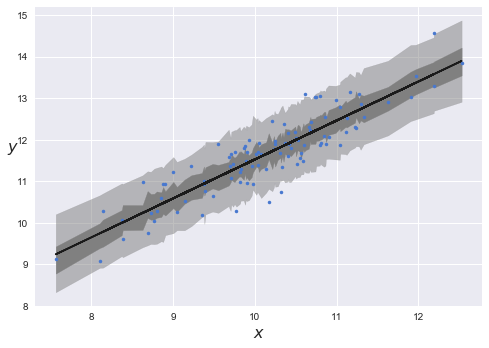

In [20]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_09.png', dpi=300, figsize=(5.5, 5.5));

## Pearson correlation coefficient

In [21]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)

    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)

    #start = pm.find_MAP()
    #step = pm.NUTS()
    #trace_n = pm.sample(2000, step=step, start=start)
    
    trace_n = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '10654' (I am process '11408')
Average Loss = 101.1:  11%|█         | 21096/200000 [00:03<00:31, 5599.05it/s] 
Convergence archived at 21300
Interrupted at 21,300 [10%]: Average Loss = 266.46
100%|██████████| 2500/2500 [00:10<00:00, 244.13it/s]


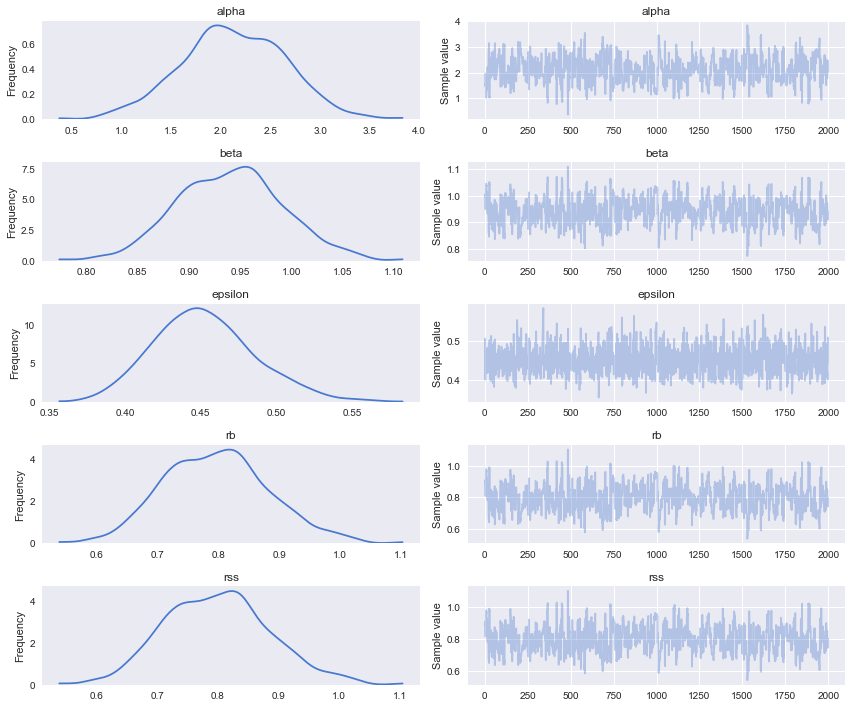

In [22]:
pm.traceplot(trace_n)
plt.savefig('B04958_04_10.png', dpi=300, figsize=(5.5, 5.5));

In [23]:
pm.df_summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.13,0.52,2.63e-02,1.02,3.04
beta,0.94,0.05,2.58e-03,0.84,1.04
epsilon,0.45,0.03,9.74e-04,0.39,0.52
rb,0.80,0.09,4.34e-03,0.63,0.96
rss,0.80,0.09,4.35e-03,0.63,0.97


### The multivariate normal distribution 
Actualy the bivariate

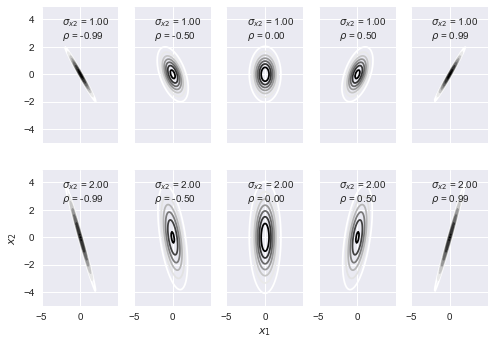

In [24]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
plt.savefig('B04958_04_11.png', dpi=300, figsize=(5.5, 5.5));

In [25]:
data = np.stack((x, y)).T

In [26]:
with pm.Model() as pearson_model:
    
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('simga_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)
    
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_p = pm.sample(1000, step=step, start=start)
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 220.77:  10%|█         | 20947/200000 [00:26<03:55, 758.83it/s]
Convergence archived at 21000
Interrupted at 21,000 [10%]: Average Loss = 312.78
100%|██████████| 1500/1500 [00:35<00:00, 42.78it/s]


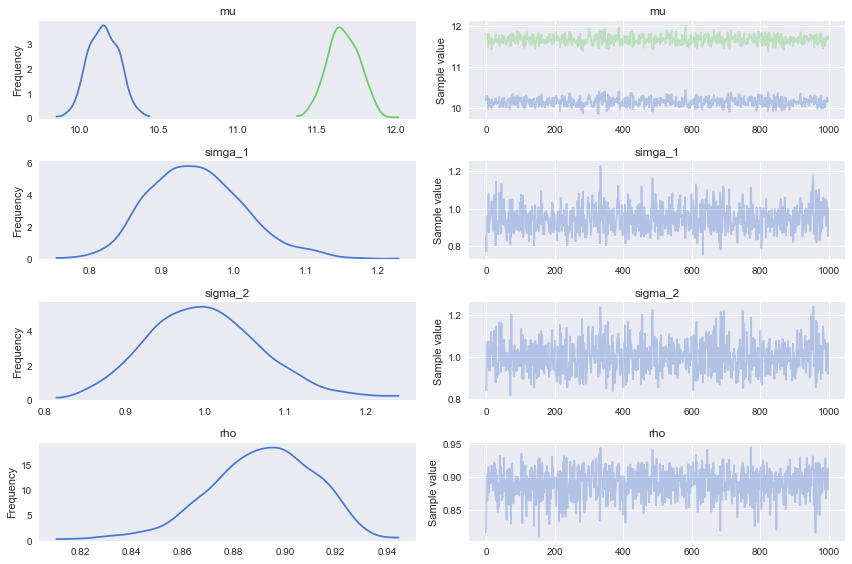

In [27]:
pm.traceplot(trace_p);
plt.savefig('B04958_04_12.png', dpi=300, figsize=(5.5, 5.5));

In [28]:
pm.df_summary(trace_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu__0,10.15,0.10,4.69e-03,9.97,10.34
mu__1,11.67,0.10,4.97e-03,11.48,11.87
simga_1,0.95,0.07,2.67e-03,0.82,1.08
sigma_2,1.00,0.07,2.70e-03,0.85,1.13
rho,0.89,0.02,7.62e-04,0.85,0.93


## Robust linear regression

In [29]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

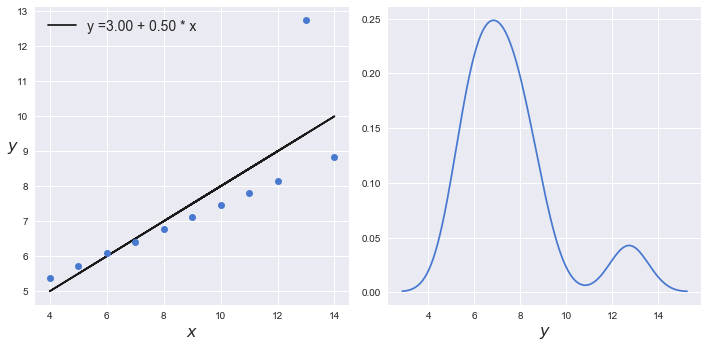

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_13.png', dpi=300, figsize=(5.5, 5.5));

In [31]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3, sd=epsilon, nu=nu, observed=y_3)

    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start) 
    #trace_t = pm.sample(2000, step=step, start=start)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 33.812:   5%|▌         | 10454/200000 [00:02<00:37, 5078.23it/s]
Convergence archived at 10500
Interrupted at 10,500 [5%]: Average Loss = 40.586
100%|█████████▉| 2499/2500 [01:11<00:00, 80.19it/s] /home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.213180766702, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [01:11<00:00, 34.92it/s]


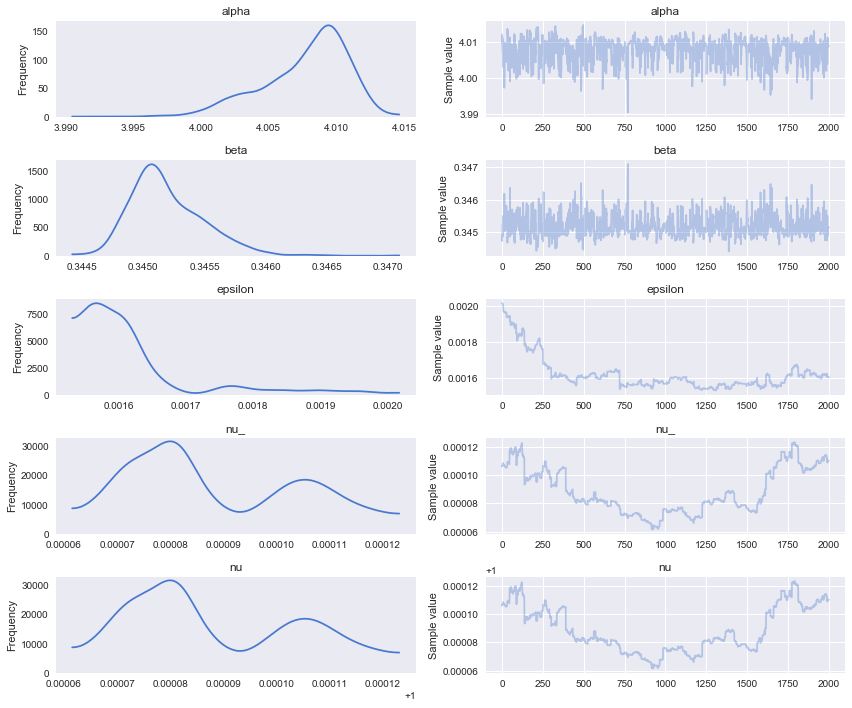

In [32]:
pm.traceplot(trace_t);

In [33]:
pm.df_summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.01e+00,3.14e-03,1.26e-04,4.00e+00,4.01e+00
beta,3.45e-01,3.01e-04,1.20e-05,3.45e-01,3.46e-01
epsilon,1.62e-03,9.42e-05,9.36e-06,1.53e-03,1.86e-03
nu_,8.86e-05,1.60e-05,1.59e-06,6.32e-05,1.17e-04
nu,1.00e+00,1.60e-05,1.59e-06,1.00e+00,1.00e+00


In [34]:
#pm.autocorrplot(cadena_t, varnames);

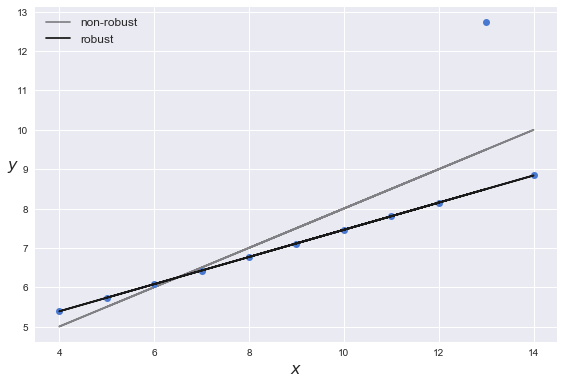

In [35]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

plt.savefig('B04958_04_14.png', dpi=300, figsize=(5.5, 5.5));

In [36]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████| 200/200 [00:00<00:00, 221.83it/s]


/home/osvaldo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


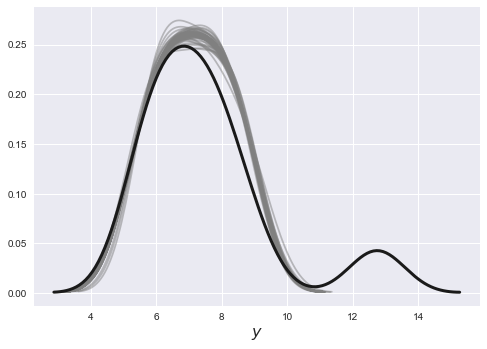

In [37]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)
plt.savefig('B04958_04_15.png', dpi=300, figsize=(5.5, 5.5));

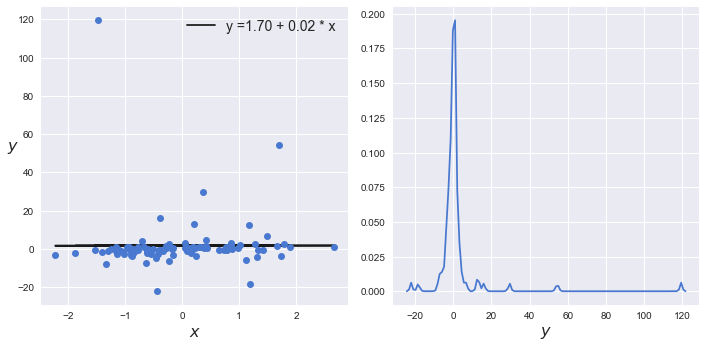

In [38]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

## Hierarchical linear regression

In [44]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

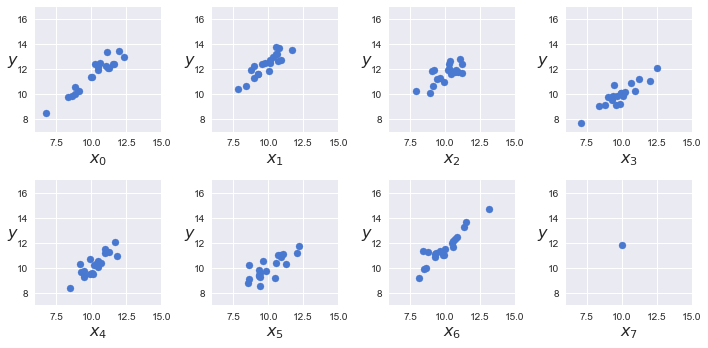

In [45]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_16.png', dpi=300, figsize=(5.5, 5.5));

In [46]:
x_centered = x_m - x_m.mean()

In [47]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_up = pm.sample(2000, step=step, start=start)
    
    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 527.59:   6%|▌         | 11504/200000 [00:02<00:47, 3930.26it/s]
Convergence archived at 11800
Interrupted at 11,800 [5%]: Average Loss = 599.7
100%|██████████| 2500/2500 [00:40<00:00, 62.13it/s]


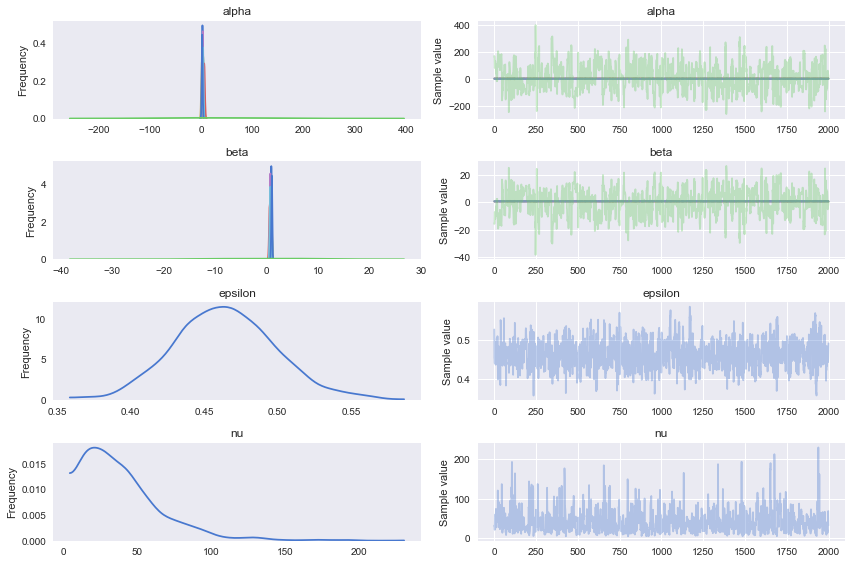

In [48]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)
plt.savefig('B04958_04_17.png', dpi=300, figsize=(5.5, 5.5));

In [49]:
#pm.autocorrplot(trace_up, varnames=[epsilon, nu]);

In [50]:
pm.df_summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.44,0.79,1.74e-02,0.85,3.94
alpha__1,3.72,1.15,2.42e-02,1.26,5.74
alpha__2,5.64,1.33,2.99e-02,2.77,7.99
alpha__3,3.09,0.88,2.18e-02,1.44,4.98
alpha__4,1.31,1.31,2.81e-02,-1.22,3.79
alpha__5,3.24,1.05,2.02e-02,1.13,5.23
alpha__6,1.77,0.90,2.07e-02,0.13,3.66
alpha__7,16.42,99.28,5.14e+00,-163.55,209.00
beta__0,0.89,0.08,1.70e-03,0.75,1.06
beta__1,0.88,0.12,2.42e-03,0.67,1.11


In [51]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    
    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    #mu, sds, elbo = pm.variational.advi(n=100000)
    #cov_scal = np.power(hierarchical_model.dict_to_array(sds), 2)
    #step = pm.NUTS(scaling=cov_scal, is_cov=True)
    #trace_hm = pm.sample(1000, step=step, start=mu)
    
    # Now we can just do:
    trace_hm = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 138.28:  30%|██▉       | 59135/200000 [00:19<00:43, 3249.63it/s]
Convergence archived at 59300
Interrupted at 59,300 [29%]: Average Loss = 367.58
100%|██████████| 1500/1500 [00:10<00:00, 143.97it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 23 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



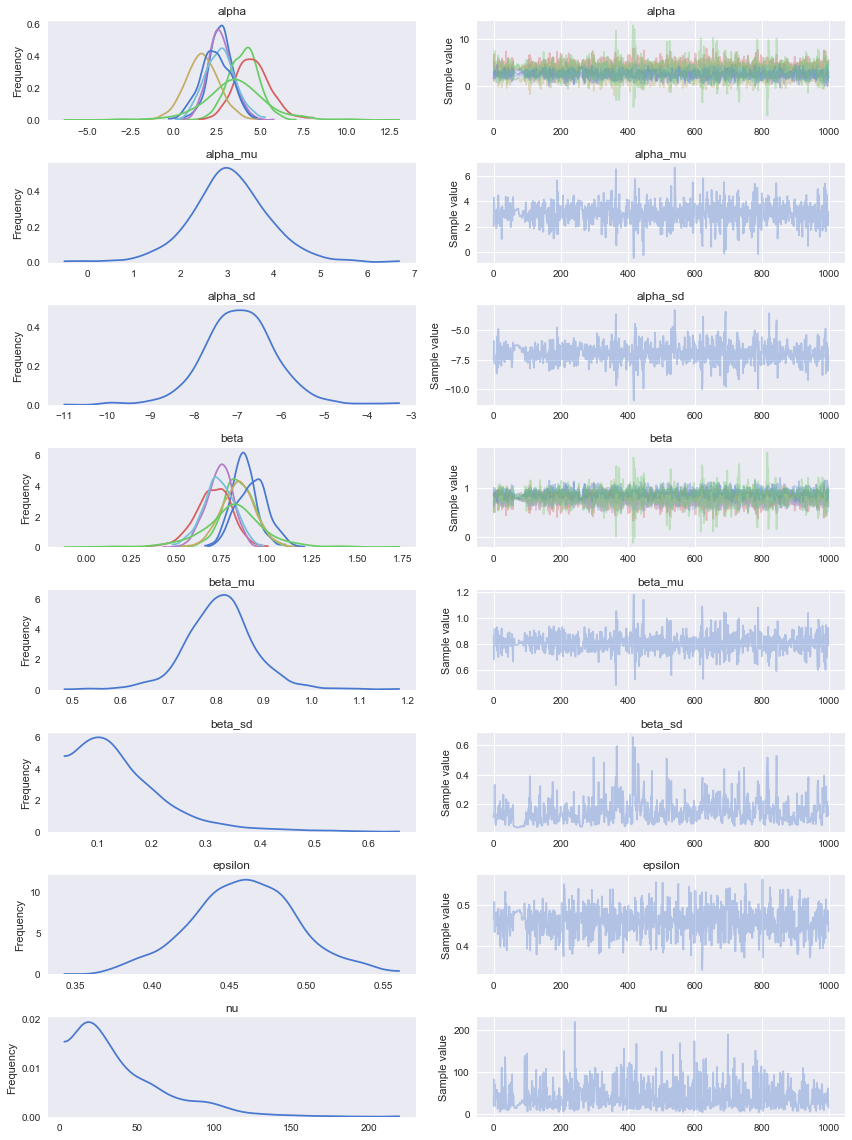

In [52]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)
plt.savefig('B04958_04_19.png', dpi=300, figsize=(5.5, 5.5));

In [53]:
pm.df_summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,2.69,0.69,1.85e-02,1.34,4.14
alpha__1,4.02,0.88,2.56e-02,2.31,5.75
alpha__2,4.57,1.03,4.04e-02,2.66,6.60
alpha__3,2.70,0.73,2.09e-02,1.41,4.19
alpha__4,1.64,0.98,2.60e-02,-0.22,3.64
alpha__5,2.68,0.87,3.00e-02,0.94,4.39
alpha__6,2.39,0.87,3.40e-02,0.78,4.12
alpha__7,3.49,2.00,5.74e-02,-0.44,7.57
alpha_mu,3.03,0.87,2.46e-02,1.31,4.79
alpha_sd,-6.94,0.86,2.59e-02,-8.47,-5.08


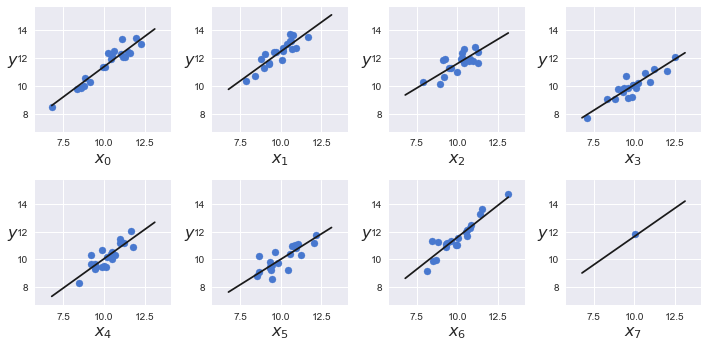

In [55]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k',
             label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_20.png', dpi=300, figsize=(5.5, 5.5));

## Polynomial regression

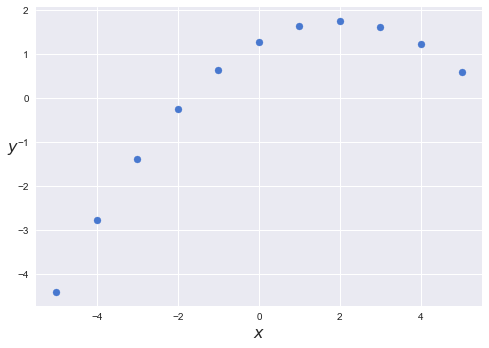

In [56]:
#ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_21.png', dpi=300, figsize=(5.5, 5.5))

In [57]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)

    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_poly = pm.sample(2000, step=step, start=start)
    
    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 27.326:  10%|█         | 20160/200000 [00:03<00:33, 5334.55it/s]
Convergence archived at 20600
Interrupted at 20,600 [10%]: Average Loss = 36.413
100%|██████████| 2500/2500 [02:20<00:00, 14.85it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 49 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



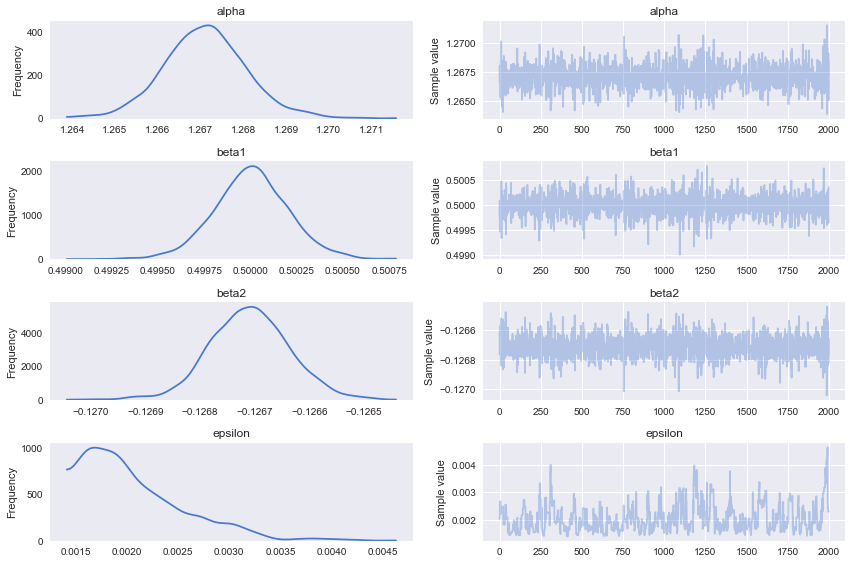

In [58]:
pm.traceplot(trace_poly)
plt.savefig('B04958_04_22.png', dpi=300, figsize=(5.5, 5.5))

In [59]:
pm.df_summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.27e+00,9.77e-04,2.35e-05,1.27e+00,1.27e+00
beta1,5.00e-01,2.03e-04,4.13e-06,5.00e-01,5.00e-01
beta2,-1.27e-01,7.45e-05,1.72e-06,-1.27e-01,-1.27e-01
epsilon,2.07e-03,5.05e-04,3.94e-05,1.42e-03,3.06e-03


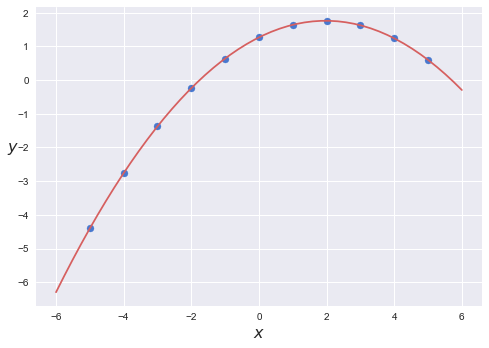

In [60]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='r')
plt.savefig('B04958_04_23.png', dpi=300, figsize=(5.5, 5.5))

## Multiple Linear regression

In [61]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

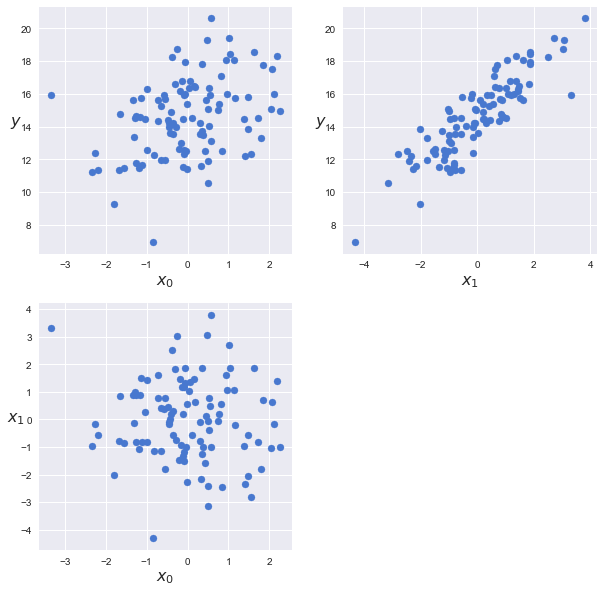

In [62]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)
plt.savefig('B04958_04_25.png', dpi=300, figsize=(5.5, 5.5))

In [63]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_mlr = pm.sample(5000, step=step, start=start)
    
    trace_mlr = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 377.73:   9%|▉         | 17891/200000 [00:03<00:35, 5149.71it/s]
Convergence archived at 18200
Interrupted at 18,200 [9%]: Average Loss = 466.08
100%|██████████| 5500/5500 [00:16<00:00, 325.15it/s]


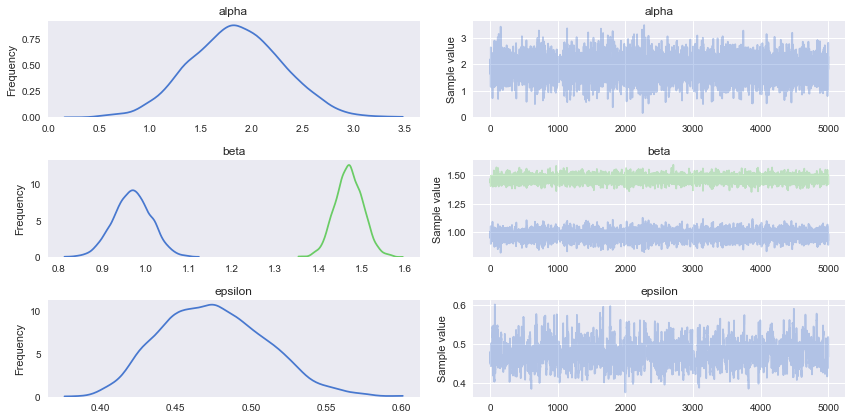

In [64]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames)
plt.savefig('B04958_04_26.png', dpi=300, figsize=(5.5, 5.5));

In [65]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.85,0.45,5.87e-03,0.95,2.69
beta__0,0.97,0.04,5.83e-04,0.88,1.05
beta__1,1.47,0.03,3.57e-04,1.41,1.53
epsilon,0.48,0.03,1.21e-03,0.41,0.54


In [66]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.85,0.45,5.87e-03,0.95,2.69
beta__0,0.97,0.04,5.83e-04,0.88,1.05
beta__1,1.47,0.03,3.57e-04,1.41,1.53
epsilon,0.48,0.03,1.21e-03,0.41,0.54


## Confounding variables and redundant variables

In [67]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

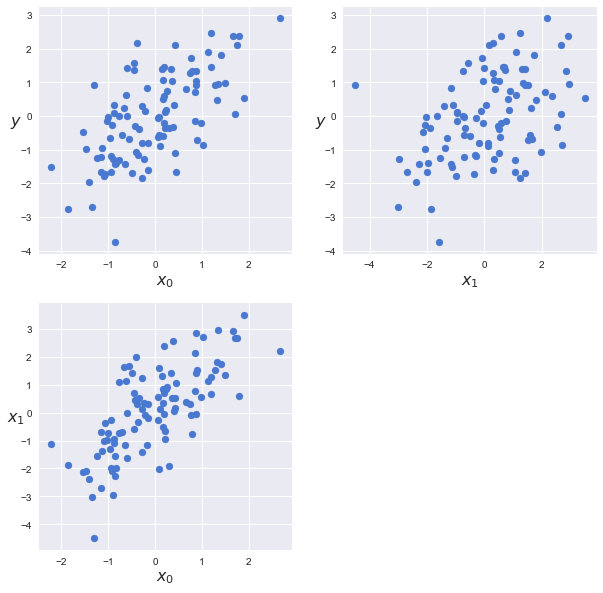

In [68]:
scatter_plot(X, y)
plt.savefig('B04958_04_27.png', dpi=300, figsize=(5.5, 5.5));

In [69]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_red = pm.sample(5000, step=step, start=start)
    
    trace_red = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 156.82:   7%|▋         | 14190/200000 [00:02<00:34, 5435.26it/s]
Convergence archived at 14700
Interrupted at 14,700 [7%]: Average Loss = 189.53
100%|██████████| 5500/5500 [00:08<00:00, 633.96it/s]


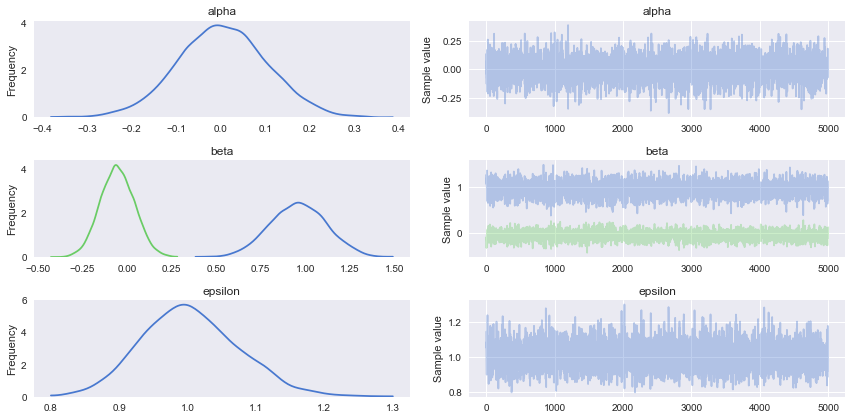

In [70]:
pm.traceplot(trace_red)
plt.savefig('B04958_04_28.png', dpi=300, figsize=(5.5, 5.5))

In [71]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,2.06e-03,0.10,1.48e-03,-0.18,0.21
beta__0,9.57e-01,0.16,3.38e-03,0.66,1.27
beta__1,-5.26e-02,0.10,2.11e-03,-0.24,0.13
epsilon,1.00e+00,0.07,9.19e-04,0.87,1.14


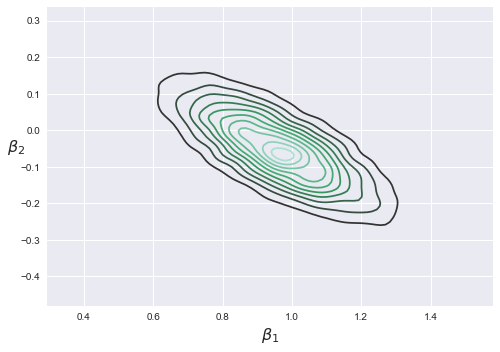

In [72]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)
#plt.savefig('B04958_04_29.png', dpi=300, figsize=(5.5, 5.5));

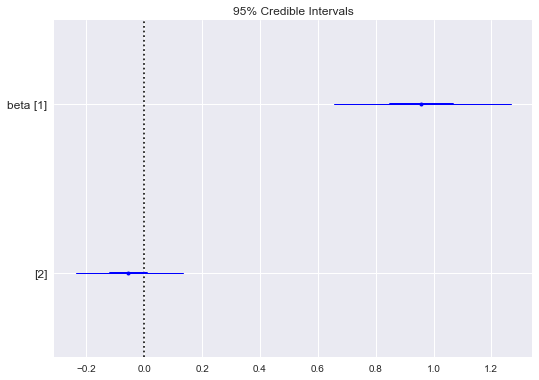

In [73]:
pm.forestplot(trace_red, varnames=['beta'])
#plt.savefig('B04958_04_30.png', dpi=300, figsize=(5.5, 5.5))

## Masking effect variables

In [74]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

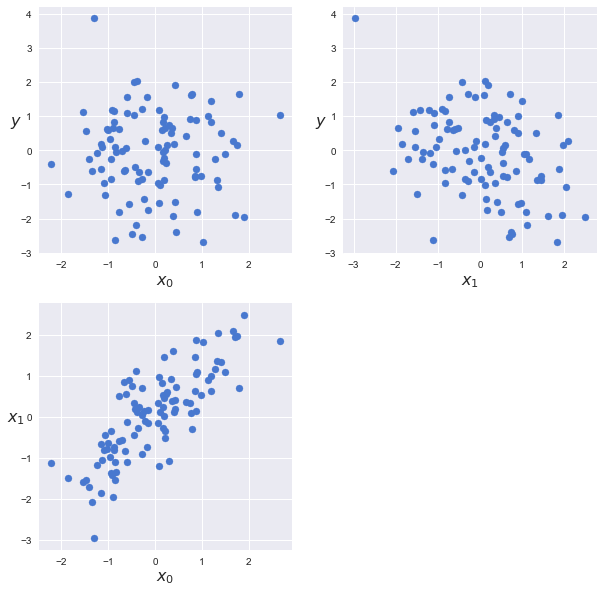

In [75]:
scatter_plot(X, y)
plt.savefig('B04958_04_31.png', dpi=300, figsize=(5.5, 5.5));

In [76]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    #trace_ma = pm.sample(5000, step=step, start=start)
    
    trace_ma = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 158.79:   7%|▋         | 14631/200000 [00:02<00:34, 5349.66it/s]
Convergence archived at 14700
Interrupted at 14,700 [7%]: Average Loss = 190.96
100%|██████████| 5500/5500 [00:09<00:00, 590.93it/s]


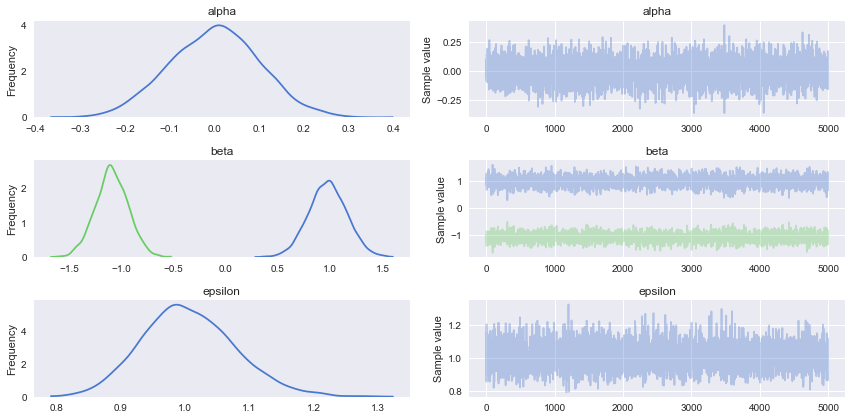

In [77]:
pm.traceplot(trace_ma)
plt.savefig('B04958_04_32.png', dpi=300, figsize=(5.5, 5.5));

In [78]:
pm.df_summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-5.30e-04,0.10,1.42e-03,-0.20,0.19
beta__0,9.77e-01,0.18,3.94e-03,0.64,1.35
beta__1,-1.09e+00,0.16,3.34e-03,-1.38,-0.76
epsilon,1.01e+00,0.07,8.46e-04,0.87,1.15


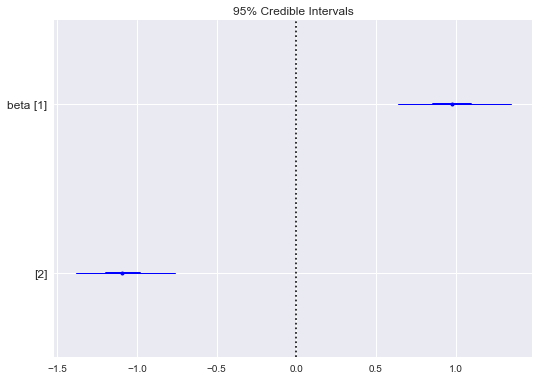

In [79]:
pm.forestplot(trace_ma, varnames=['beta']);
plt.savefig('B04958_04_33.png', dpi=300, figsize=(5.5, 5.5));

In [80]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo debian stretch/sid y usando:
Python 3.6.1
IPython 5.3.0
PyMC3 3.1
NumPy 1.12.1
SciPy 0.19.0
Matplotlib 2.0.2
Seaborn 0.7.1

